In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import itertools
import statsmodels.api as sm
import networkx as nx
import seaborn as sns
import pandas as pd

from spikeometric.models import BernoulliGLM
from spikeometric.datasets import NormalGenerator, ConnectivityDataset
from spikeometric.stimulus import RegularStimulus

from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj, to_networkx

### Create networks

In [2]:
sns.__version__

'0.13.0'

In [3]:
n_obs = 3
n_hidden = 1

index_obs = np.random.choice(n_obs+n_hidden, size = n_obs, replace = False)
n_networks = 10

# model parameters
mu=0
sigma = 10
theta = 5

generator = NormalGenerator(
    n_neurons=n_obs + n_hidden,
    mean=mu,
    std=sigma,
    glorot=True,
    sparsity=0.5
)

#load connectivity matricies
network_data = generator.generate(n_networks)

# set up the neuron model
neuron_model = BernoulliGLM(
    theta=theta,
    dt=1.,
    coupling_window=2,
    abs_ref_scale=2,
    abs_ref_strength=-100,
    rel_ref_scale=0,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

In [31]:
edge_index = torch.tensor([[0, 0, 1, 2],
                           [1, 2, 2, 3]])

W0 = torch.tensor([6.0, 7.5, 2.2, 1.4])

dataset = Data(num_nodes=4, W0=W0, edge_index=edge_index)

torch.save(dataset,'data/homemade.pt')
example_network = torch.load('data/homemade.pt')

In [32]:
index_obs = np.array([1,2,3])

#### Plot full network

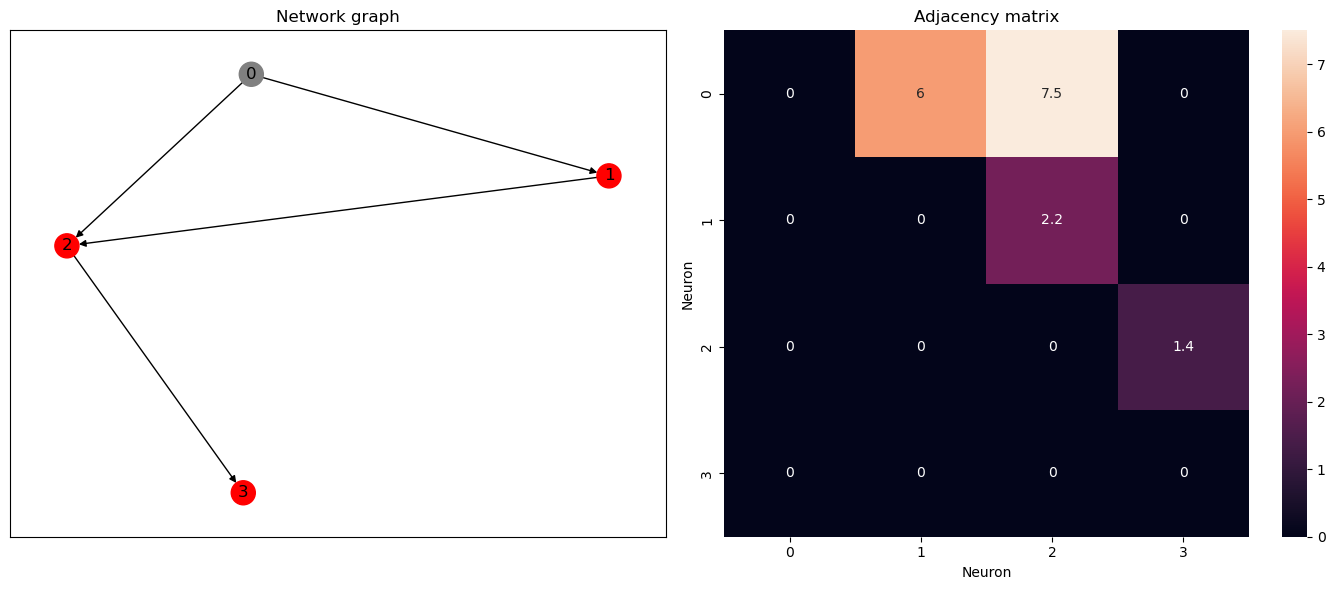

In [33]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

#example_network = network_data[5]
G = to_networkx(example_network)
color_map = ['grey' if node not in index_obs else 'red' for node in G]        

nx.draw_networkx(G, arrows=True, ax=ax[0], node_color=color_map)
ax[0].set_title("Network graph")

W0 = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=example_network.num_nodes)[0]
sns.heatmap(W0, ax=ax[1], annot=True)
ax[1].set_title("Adjacency matrix")
ax[1].set_xlabel("Neuron")
ax[1].set_ylabel("Neuron")

plt.tight_layout()
plt.show()

### Plot observed network

In [34]:
index_obs

array([1, 2, 3])

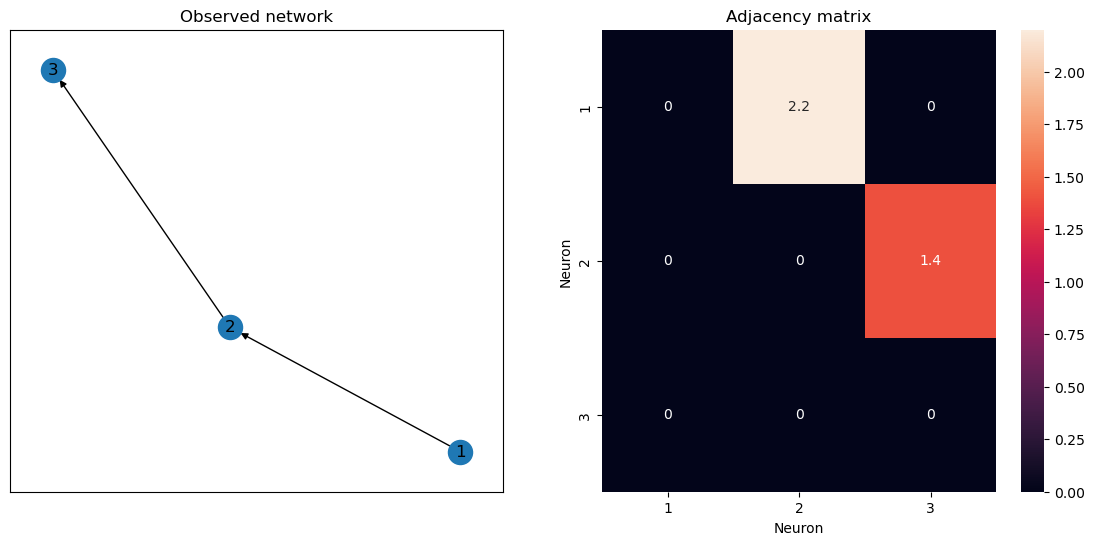

In [35]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

G_obs = nx.subgraph(G, index_obs)

nx.draw_networkx(G_obs, arrows=True, ax=ax[0])
ax[0].set_title("Observed network")

W0_obs = W0[index_obs][:, index_obs]
sns.heatmap(W0_obs, ax=ax[1], annot=True)
ax[1].set_title("Adjacency matrix")
ax[1].set_xlabel("Neuron")
ax[1].set_ylabel("Neuron")
ax[1].set_xticklabels(index_obs)
ax[1].set_yticklabels(index_obs)
#plt.tight_layout()
plt.show()

### run simulation

In [36]:
n_timesteps = 10**6
spikes = neuron_model.simulate(example_network, n_steps=n_timesteps, verbose=False)

#### Plot activity

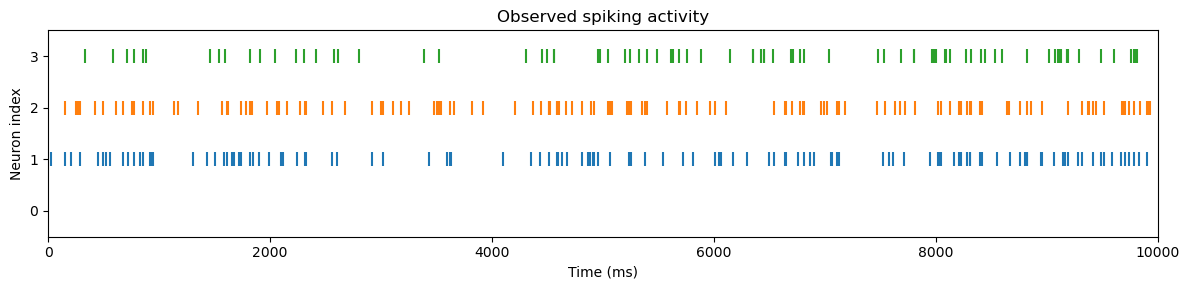

In [37]:
plt.figure(figsize=(12,3))

for i in index_obs:
    plt.scatter(np.where(spikes[i,:] == 1)[0], i*np.ones_like(np.where(spikes[i,:] == 1)[0]), marker='|', s=100)

plt.yticks(np.arange(n_obs + n_hidden))
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.xlim([0, 10_000])
plt.ylim([-0.5, n_obs + n_hidden - 0.5])
plt.title("Observed spiking activity")
plt.tight_layout()
plt.show()

### Learn structure

In [38]:
G_learned = nx.DiGraph()
G_learned.add_nodes_from(np.sort(index_obs))
alpha = 0.01 # sign. level

spikes_obs = spikes[index_obs]

for idx, neuron_id in enumerate(index_obs):
        
    target_spikes = spikes_obs[idx].numpy()
    source_spikes = np.delete(torch.roll(spikes_obs, 1), idx, axis=0) # effect from 1 time step before
    source_spikes2 = np.delete(torch.roll(spikes_obs, 2), idx, axis=0) # effect from 2 time step before
    autoregressive_feature1 = torch.roll(spikes_obs[idx], 1).numpy() # 1 time step history effects
    autoregressive_feature2 = torch.roll(spikes_obs[idx], 2).numpy() # 2 time step history effects
    
    # create design matrix
    X = np.vstack((source_spikes, source_spikes2, autoregressive_feature1, autoregressive_feature2))
    
    # use a linear regression model to assess if there is a significantly non-zero association between source and target neuron
    linear_model = sm.OLS(target_spikes.T, sm.add_constant(X.T))
    res = linear_model.fit()
    
    source_nodes = np.delete(index_obs, idx) # remove target neuron
    p_values = res.pvalues[1:n_obs] # p-values of t-test of effect from source to targat neuron (first time step coefficient)

    for k, p in enumerate(p_values):
        if p < alpha:
            G_learned.add_edge(source_nodes[k], neuron_id)


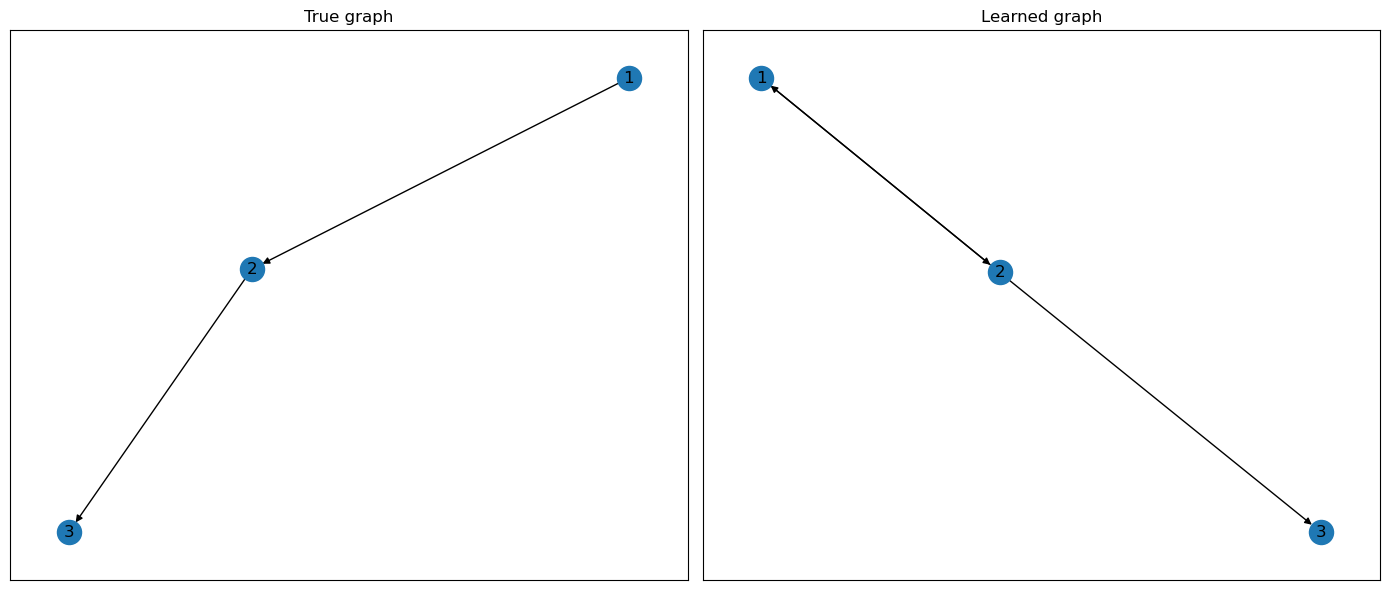

In [39]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

example_network = network_data[0]

nx.draw_networkx(G_obs, arrows=True, ax=ax[0])
ax[0].set_title("True graph")

nx.draw_networkx(G_learned, arrows=True, ax=ax[1])
ax[1].set_title("Learned graph")

plt.tight_layout()
plt.show()

In [40]:
A_true = nx.adjacency_matrix(G_obs)
A_learned = nx.adjacency_matrix(G_learned)

pd.DataFrame(A_true.todense() - A_learned.todense())

,0,1,2
0,0,0,0
1,-1,0,0
2,0,0,0


In [41]:
SHD = np.sum(np.abs(A_true.todense() - A_learned.todense()))
print(SHD)

1


In [42]:
A_true.todense()

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 0]])

In [43]:
A_learned.todense()

array([[0, 1, 0],
       [1, 0, 1],
       [0, 0, 0]])

### Notes

- best SHD achieved when autoregressive and coupling effects from all time intervals are included in the regression model
- but only test effect at first time interval
- I get an SHD value around 4-7, might be due to alpha-level?
- With smaller sample sizes than 10^6 I get a SHD of around 40-50
- weakly inhibitory connections seem harder to detect, and donnections less t

In [44]:
G_learned.edges

OutEdgeView([(1, 2), (2, 1), (2, 3)])